In [ ]:
project_name = 'GAN'

In [ ]:
from google.colab import drive
drive.mount('/content/drive') 

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!unzip /content/drive/MyDrive/data.zip 


In [ ]:
import os
DATA_DIR = 'data/malignant'

In [ ]:
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as T 

In [ ]:
image_size = 64
batch_size = 128
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

In [ ]:
train_ds = ImageFolder(DATA_DIR , transform=T.Compose([
    T.Resize(image_size),
    T.CenterCrop(image_size),
    T.ToTensor(),
    T.Normalize(*stats)]))

train_dl = DataLoader(train_ds, 
                      batch_size, 
                      shuffle=True, 
                      num_workers=3,
                      pin_memory=True)

In [ ]:
import torch
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

In [ ]:
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

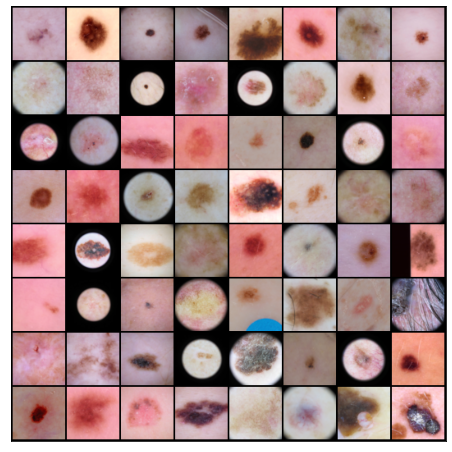

In [ ]:
show_batch(train_dl)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!pip install jovian --upgrade --quiet

In [ ]:
import jovian

In [ ]:
jovian.commit(project=project_name, environment=None)

[jovian] Detected Colab notebook...
[jovian] jovian.commit() is no longer required on Google Colab. If you ran this notebook from Jovian, 
then just save this file in Colab using Ctrl+S/Cmd+S and it will be updated on Jovian. 
Also, you can also delete this cell, it's no longer necessary.


In [ ]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
device = get_default_device()
device

device(type='cuda')

In [ ]:
train_dl = DeviceDataLoader(train_dl, device)

In [ ]:
import torch.nn as nn

In [ ]:
discriminator = nn.Sequential(
    # in: 3 x 64 x 64

    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 32 x 32

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 16 x 16

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 8 x 8

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 4 x 4

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid())

In [ ]:
discriminator = to_device(discriminator, device)

In [ ]:
latent_size = 128

In [ ]:
generator = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 16 x 16

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 32 x 32

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 3 x 64 x 64
)

torch.Size([128, 3, 64, 64])


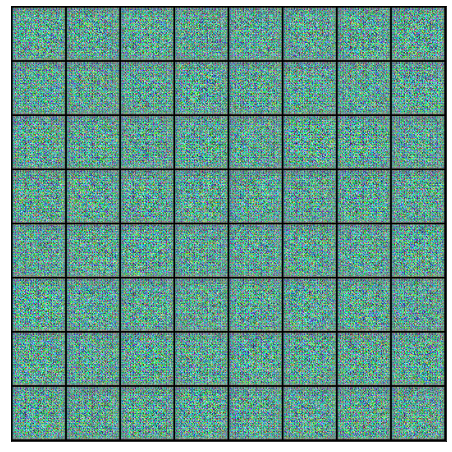

In [ ]:
xb = torch.randn(batch_size, latent_size, 1, 1) # random latent tensors
fake_images = generator(xb)
print(fake_images.shape)
show_images(fake_images)

In [ ]:
generator = to_device(generator, device)

In [ ]:
def train_discriminator(real_images, opt_d):
    # Clear discriminator gradients
    opt_d.zero_grad()

    # Pass real images through discriminator
    real_preds = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0), 1, device=device)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    # Pass fake images through discriminator
    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
    fake_preds = discriminator(fake_images)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()

    # Update discriminator weights
    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()
    return loss.item(), real_score, fake_score

In [ ]:
def train_generator(opt_g):
    # Clear generator gradients
    opt_g.zero_grad()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)
    
    # Try to fool the discriminator
    preds = discriminator(fake_images)
    targets = torch.ones(batch_size, 1, device=device)
    loss = F.binary_cross_entropy(preds, targets)
    
    # Update generator weights
    loss.backward()
    opt_g.step()
    
    return loss.item()

In [ ]:
from torchvision.utils import save_image

In [ ]:
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

In [ ]:
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

In [ ]:
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)

Saving generated-images-0000.png


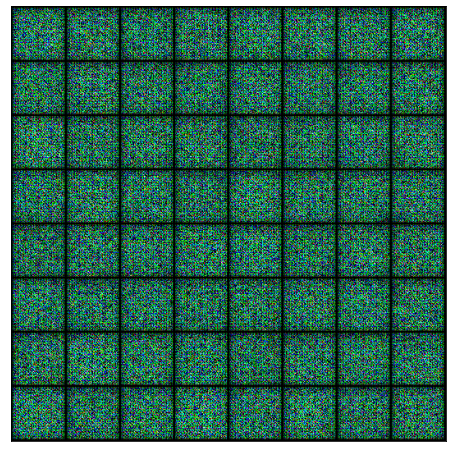

In [ ]:
save_samples(0, fixed_latent)

In [ ]:
jovian.commit(project=project_name, environment=None)

[jovian] Detected Colab notebook...
[jovian] jovian.commit() is no longer required on Google Colab. If you ran this notebook from Jovian, 
then just save this file in Colab using Ctrl+S/Cmd+S and it will be updated on Jovian. 
Also, you can also delete this cell, it's no longer necessary.


In [ ]:
from tqdm.notebook import tqdm
import torch.nn.functional as F

In [ ]:
def fit(epochs, lr, start_idx=1):
    torch.cuda.empty_cache()
    
    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []
    
    # Create optimizers
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
    
    for epoch in range(epochs):
        for real_images, _ in tqdm(train_dl):
            # Train discriminator
            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
            # Train generator
            loss_g = train_generator(opt_g)
            
        # Record losses & scores
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)
        
        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, loss_g, loss_d, real_score, fake_score))
    
        # Save generated images
        save_samples(epoch+start_idx, fixed_latent, show=False)
    
    return losses_g, losses_d, real_scores, fake_scores

In [ ]:
lr = 0.0002
epochs = 25

In [ ]:
jovian.reset()
jovian.log_hyperparams(lr=lr, epochs=epochs)

[jovian] Please enter your API key ( from https://jovian.ai/ ):
API KEY: ··········
[jovian] Hyperparams logged.


In [ ]:
history = fit(epochs, lr)

  0%|          | 0/203 [00:00<?, ?it/s]

Epoch [1/25], loss_g: 4.0852, loss_d: 0.0566, real_score: 0.9785, fake_score: 0.0338
Saving generated-images-0001.png


  0%|          | 0/203 [00:00<?, ?it/s]

Epoch [2/25], loss_g: 6.8825, loss_d: 0.0047, real_score: 0.9985, fake_score: 0.0032
Saving generated-images-0002.png


  0%|          | 0/203 [00:00<?, ?it/s]

Epoch [3/25], loss_g: 5.3650, loss_d: 0.1351, real_score: 0.9580, fake_score: 0.0774
Saving generated-images-0003.png


  0%|          | 0/203 [00:00<?, ?it/s]

Epoch [4/25], loss_g: 1.1432, loss_d: 0.5584, real_score: 0.8646, fake_score: 0.2800
Saving generated-images-0004.png


  0%|          | 0/203 [00:00<?, ?it/s]

Epoch [5/25], loss_g: 3.3163, loss_d: 0.2416, real_score: 0.9305, fake_score: 0.1455
Saving generated-images-0005.png


  0%|          | 0/203 [00:00<?, ?it/s]

Epoch [6/25], loss_g: 2.1984, loss_d: 0.8369, real_score: 0.8058, fake_score: 0.4208
Saving generated-images-0006.png


  0%|          | 0/203 [00:00<?, ?it/s]

Epoch [7/25], loss_g: 4.2354, loss_d: 1.4524, real_score: 0.9406, fake_score: 0.7016
Saving generated-images-0007.png


  0%|          | 0/203 [00:00<?, ?it/s]

Epoch [8/25], loss_g: 1.8304, loss_d: 0.7123, real_score: 0.5787, fake_score: 0.0709
Saving generated-images-0008.png


  0%|          | 0/203 [00:00<?, ?it/s]

Epoch [9/25], loss_g: 4.3903, loss_d: 1.0928, real_score: 0.3858, fake_score: 0.0056
Saving generated-images-0009.png


  0%|          | 0/203 [00:00<?, ?it/s]

Epoch [10/25], loss_g: 5.2238, loss_d: 0.3046, real_score: 0.7539, fake_score: 0.0080
Saving generated-images-0010.png


  0%|          | 0/203 [00:00<?, ?it/s]

Epoch [11/25], loss_g: 2.4579, loss_d: 0.1245, real_score: 0.9787, fake_score: 0.0960
Saving generated-images-0011.png


  0%|          | 0/203 [00:00<?, ?it/s]

Epoch [12/25], loss_g: 3.5104, loss_d: 0.6839, real_score: 0.8680, fake_score: 0.3997
Saving generated-images-0012.png


  0%|          | 0/203 [00:00<?, ?it/s]

Epoch [13/25], loss_g: 3.3715, loss_d: 0.0807, real_score: 0.9579, fake_score: 0.0365
Saving generated-images-0013.png


  0%|          | 0/203 [00:00<?, ?it/s]

Epoch [14/25], loss_g: 4.8422, loss_d: 0.2343, real_score: 0.8030, fake_score: 0.0086
Saving generated-images-0014.png


  0%|          | 0/203 [00:00<?, ?it/s]

Epoch [15/25], loss_g: 8.6573, loss_d: 0.0060, real_score: 0.9942, fake_score: 0.0002
Saving generated-images-0015.png


  0%|          | 0/203 [00:00<?, ?it/s]

Epoch [16/25], loss_g: 7.8701, loss_d: 0.0442, real_score: 0.9573, fake_score: 0.0003
Saving generated-images-0016.png


  0%|          | 0/203 [00:00<?, ?it/s]

Epoch [17/25], loss_g: 8.8024, loss_d: 0.0028, real_score: 0.9974, fake_score: 0.0002
Saving generated-images-0017.png


  0%|          | 0/203 [00:00<?, ?it/s]

Epoch [18/25], loss_g: 6.5928, loss_d: 0.0217, real_score: 0.9813, fake_score: 0.0027
Saving generated-images-0018.png


  0%|          | 0/203 [00:00<?, ?it/s]

Epoch [19/25], loss_g: 8.4153, loss_d: 1.0330, real_score: 0.9855, fake_score: 0.6184
Saving generated-images-0019.png


  0%|          | 0/203 [00:00<?, ?it/s]

Epoch [20/25], loss_g: 3.1828, loss_d: 0.3611, real_score: 0.9750, fake_score: 0.2598
Saving generated-images-0020.png


  0%|          | 0/203 [00:00<?, ?it/s]

Epoch [21/25], loss_g: 7.3792, loss_d: 0.0312, real_score: 0.9705, fake_score: 0.0011
Saving generated-images-0021.png


  0%|          | 0/203 [00:00<?, ?it/s]

Epoch [22/25], loss_g: 4.6027, loss_d: 0.1111, real_score: 0.9688, fake_score: 0.0751
Saving generated-images-0022.png


  0%|          | 0/203 [00:00<?, ?it/s]

Epoch [23/25], loss_g: 8.7192, loss_d: 0.8498, real_score: 0.4556, fake_score: 0.0001
Saving generated-images-0023.png


  0%|          | 0/203 [00:00<?, ?it/s]

Epoch [24/25], loss_g: 6.7900, loss_d: 2.6276, real_score: 0.9875, fake_score: 0.9105
Saving generated-images-0024.png


  0%|          | 0/203 [00:00<?, ?it/s]

Epoch [25/25], loss_g: 4.7525, loss_d: 0.5938, real_score: 0.8773, fake_score: 0.3491
Saving generated-images-0025.png
